# Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers. 

## 1. Problem Definition

> How well can we predict the future sale price of a bullsozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from Kaggle Bluebook for Bulldozers Competition. 

There are three main datasets:

* Train.csv is the training set, which contains data through the end of 2011.

* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RSMLE> 

## 4. Features

Kaggle provides a data dictionary: 
https://docs.google.com/spreadsheets/d/1eFEhVmWRA8E-AZie4mWHbKhQlK7VPm9_ZQQw3MswaeU/edit?usp=sharing


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [18]:
# Import traning and validation sets
df = pd.read_csv("data/bluebook-for-bulldozers/TrainandValid.csv", 
                low_memory=False)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [20]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

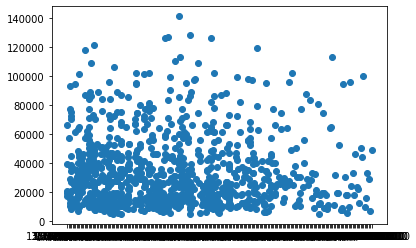

In [21]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

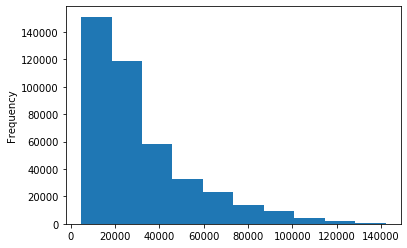

In [22]:
df.SalePrice.plot.hist()

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible. 

We can do that by telling pandas which of our columns has dates in it using the 'parse_dates' parameters.

In [23]:
# Import data again but this time parse dates
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", 
                low_memory=False, 
                parse_dates=["saledate"])

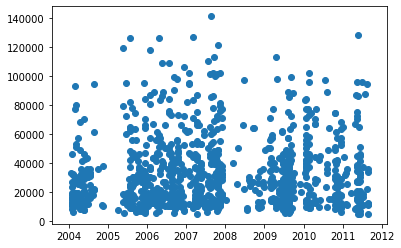

In [24]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date

In [25]:
# Sort
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

# We make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original

In [32]:
# Make a copy
df_tmp = df.copy()

### Add datetime parameters for `saledate` column

In [33]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayofWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofYear"] = df_tmp.saledate.dt.dayofyear

In [34]:
# Now we've enriched our DataFrame with date time features, we can remove saledate
df_tmp.drop("saledate", axis=1, inplace=True)

In [35]:
# Check the values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modelling

We've done enough EDA (we could always do more) but let's start to do some model-drive EDA. 

In [37]:
# Let's build a machine learning model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, 
                             random_state=42)

model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

ValueError: could not convert string to float: 'Low'

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 1

 Data is missing and some data isn't numeric

## Convert strings to categories

One way we can turn all of our data into numbers is by converting them into pandas categories

In [45]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofWeek,saleDayofYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [41]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [43]:
# Find columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [44]:
# If you're wondering what df.items() does, here's an example
random_dict = {"key1": "hello", 
              "key2": "world!"}

for key, value in random_dict.items():
    print(f"this is a key: {key}",
         f"this is a value: {value}")

this is a key: key1 this is a value: hello
this is a key: key2 this is a value: world!


In [47]:
# This will turn all of the string values in category values

for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()


In [48]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [50]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas Categories we now have a way to access all of our data in the form of numbers. 

But we still have a bunch of missing data...

In [51]:
# Check missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save pre-processed data

In [52]:
# Export current tmp dataframe
df_tmp.to_csv("data/bluebook-for-bulldozers/train_tmp.csv", 
             index=False)

In [53]:
# Import preprocessed data
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp.csv", 
                    low_memory=False)

In [54]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

## Fill missing values

### Fill numeric missing values first

In [55]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayofWeek
saleDayofYear


In [57]:
# Check for which numeric columns have null values 
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [59]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric with median
            df_tmp[label] = content.fillna(content.median())
            # Median is more robust and less sensitive to outliers than the mean

In [60]:
# check if there's any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [61]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

### Filling and turning categorical variables into numbers

In [63]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [68]:
# Turn categorical variabels in numbers and fill missing
for label,content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a binary column which tells us if the data was missing or not
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes+1
            

In [64]:
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [69]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [70]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [72]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all of data is numeric as well as our datafram has no missing values, we should be able to build a machine learning model. 

In [73]:
%%time
# Instantiate model 
model = RandomForestRegressor(n_jobs=-1, 
                             random_state=42)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

CPU times: user 19min 41s, sys: 10.6 s, total: 19min 52s
Wall time: 3min 10s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [74]:
# Score the model 
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

0.9875468079970563

**Question:** Why doesn't the above metric hold water?
   
 We used the same data to train and fit the model.

### Splitting data into train/validation sets

In [77]:
df_tmp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

In [78]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [79]:
# Splut data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [81]:
# Split data into x and y 
x_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
x_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an evaluation function

In [90]:
# Create evaluation function (RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    
    """
    Calculates root mean squared log error between predictions and true labels.
    """

    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few fifferent levels
def show_scores(model):
    train_preds = model.predict(x_train)
    val_preds = model.predict(x_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds), 
             "Valid MAE": mean_absolute_error(y_valid, val_preds), 
             "Training RSMLE": rmsle(y_train, train_preds), 
             "Valid RSMLE": rmsle(y_valid, val_preds), 
             "Training R^2": r2_score(y_train, train_preds), 
             "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

## Testing our model on a subset (to tune the hyperparameters)

In [85]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1, 
                             random_state=42, 
                             max_samples=10000)

In [86]:
%%time
model.fit(x_train, y_train)

CPU times: user 1min 7s, sys: 1.59 s, total: 1min 8s
Wall time: 14.5 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [96]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RSMLE': 0.257745378256977,
 'Valid RSMLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

### Hyperparameter tuning with RandomizedSearchCV

In [98]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegression hyperparameters
rf_grid = {"n_estimators": np.arange(10,100,10), 
          "max_depth": [None, 3, 5, 10], 
          "min_samples_split": np.arange(2,20,2), 
          "min_samples_leaf": np.arange(1,20,2),
          "max_features": [0.5, 1, "sqrt", "auto"], 
          "max_samples": [10000]}

# Instantiate RandomizedSearchCV Model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, 
                                                   random_state=42), 
                             param_distributions=rf_grid, 
                             n_iter=2, 
                             cv=5, 
                             verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.9s finished


CPU times: user 37.7 s, sys: 4.24 s, total: 41.9 s
Wall time: 43.6 s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [99]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 18,
 'min_samples_leaf': 7,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [100]:
# Evaluate the RandomizedSearch model 
show_scores(rs_model)

{'Training MAE': 6276.9180217292005,
 'Valid MAE': 7631.118676392893,
 'Training RSMLE': 0.28377555424681344,
 'Valid RSMLE': 0.30776747116017444,
 'Training R^2': 0.824965616449262,
 'Valid R^2': 0.8098575276273299}

### Train a model with the best hyperparameters

**Note**: These were found after 100 iterations of `RandomizedSearchCV`

In [102]:
%%time
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40, 
                                   min_samples_leaf=1, 
                                   min_samples_split=14, 
                                   max_features=0.5, 
                                   n_jobs=-1, 
                                   max_samples=None, 
                                    random_state=42)

# Fit the ideal model 
ideal_model.fit(x_train, y_train)

CPU times: user 3min 41s, sys: 1.81 s, total: 3min 42s
Wall time: 34.7 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [103]:
show_scores(ideal_model)

{'Training MAE': 2948.1521959753863,
 'Valid MAE': 5962.02156248879,
 'Training RSMLE': 0.1443985613515476,
 'Valid RSMLE': 0.24643276607561537,
 'Training R^2': 0.9590234905933226,
 'Valid R^2': 0.8814699203244046}

## Make predictions on test data

In [129]:
# Import the test data
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv", 
                     low_memory=False, 
                     parse_dates=["saledate"])

In [130]:
# Make predictions on the test dataset
test_preds = ideal_model.predict(df_test)

ValueError: could not convert string to float: 'Low'

## Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [131]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df. 
    """
    
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofWeek"] = df.saledate.dt.dayofweek
    df["saleDayofYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric with median
                df[label] = content.fillna(content.median())
                # Median is more robust and less sensitive to outliers than the mean

    
    
        # Filled categorical missing data and turned categories into numbers. 
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [132]:
# Process the test data
df_test = preprocess_data(df_test)

In [133]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test)

ValueError: Number of features of the model must match the input. Model n_features is 102 and input n_features is 101 

In [134]:
# We can find how the columns differ using sets
set(x_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [135]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


Finally now our test dataframe has the same features as our training dataframe, we can make predictions

In [136]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test)

In [137]:
test_preds

array([21039.47333266, 20461.64710062, 49930.02444969, ...,
       15298.90522081, 17988.61916567, 30027.31261681])

In [138]:
# Format prediction into the same format Kaggle is after
df_preds = pd.DataFrame()

df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrices"] = test_preds
df_preds

,SalesID,SalesPrices
0,1227829,21039.473333
1,1227844,20461.647101
2,1227847,49930.024450
3,1227848,58757.651595
4,1227863,54412.604057
...,...,...
12452,6643171,44659.093028
12453,6643173,15847.623624
12454,6643184,15298.905221
12455,6643186,17988.619166


In [139]:
# Export prediction data
df_preds.to_csv("data/bluebook-for-bulldozers/test_predictions.csv", index=False)

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the target variable (SalePrice)

In [140]:
# Find feature importance of our best model 
ideal_model.feature_importances_

array([3.38200361e-02, 1.53192860e-02, 4.62479327e-02, 1.93575471e-03,
       3.30927551e-03, 2.09829659e-01, 3.12157050e-03, 1.07805808e-03,
       4.86833140e-02, 4.45121589e-02, 6.44809164e-02, 4.72742894e-03,
       1.32220813e-02, 1.57602962e-01, 4.18885603e-02, 5.96816740e-03,
       4.56209149e-03, 2.00276613e-03, 3.04954584e-03, 5.14893087e-02,
       6.01778696e-04, 3.77980802e-05, 8.08922793e-04, 4.96277688e-04,
       1.28838491e-03, 2.28689502e-05, 2.04934865e-03, 1.29385534e-02,
       2.75256264e-04, 2.04089705e-03, 2.49065579e-03, 2.44531007e-03,
       3.23444325e-03, 4.20601245e-04, 2.36377315e-04, 6.62339614e-03,
       1.08797409e-03, 1.16926633e-02, 7.24148425e-04, 2.34580804e-03,
       8.81263574e-04, 9.82440979e-04, 1.11713328e-03, 5.47625293e-04,
       4.80847847e-04, 3.73939625e-04, 2.25060792e-04, 2.16623318e-03,
       9.73790636e-04, 1.96204821e-04, 2.55719751e-04, 7.31841931e-02,
       3.79003854e-03, 5.63555832e-03, 2.92452265e-03, 9.98056295e-03,
      

In [146]:
# helper function fo plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns, 
                       "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    
    # Plot the dataframe
    fix, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Immportance")
    ax.invert_yaxis()

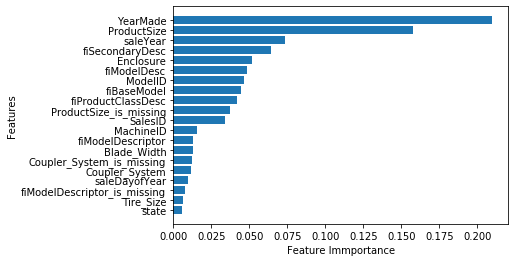

In [147]:
plot_features(x_train.columns, ideal_model.feature_importances_)

**Questions to finish:** WJy might knowing the feature importances of a trained machine learnign model be helpful?